## Dataset I. target_dataset
<br>
<img src="./images/target_dataset.png"/>

Explanation for the columns:
1. `person` (int)
    - Id for person: already encoded to int number
2. `offer_id` (object of str)
    - Id for offer: already encoded to int number
    - **Values**: from '0' to '9'
3. `time_received` (float)
    - time of reveiving the offer
    - **Values**: `NaN` represent not received
4. `time_viewed` (float) 
    - time of viewing the offer
    - **Values**: `NaN` represent not viewed
5. `time_transaction` (object of str)
    - time of the transactions within an transaction unit(within one unique offer_id of one person, there may be more transaction units)
    - **Values**: there maybe more than one transactions within a transaction unit, so use `str`(obeject) to represent
        - for offer is informational(offer_id is 2 or 7)
            - there is only one value(float): None or the first transaction time
        - for other offers
            - `''` means there is no transaction
            - `',3.8,5.9'` means there is two transactions, one is at time 3.8, another in at time 5.9 
        
6. `time_completed` (float)
    - time of complete the offer
    - **Values**: `NaN` represent not completed
7. `amount_with_offer` (float)
    - amount of transaction(s) within this transaction unit
    - **Values**: '0.0' represent no transaction
8. `label_effective_offer` (int) **!!!Attention: there is no infomation about 'offer viewed'**
    - the label to mark the completion level of offer
    - **Values**:
        - `1`: 
            - for informational offer there is at least one transaction within duration; 
            - for other offer there should be 'offer completed'
        - `0`: 
            - for informational offer there is no valid transaction within the duration but 'offer received'; 
            - for other offers there is no 'offer completed', but within duration there maybe some amount, although the amount of transactions not fulfil requirements
        - `-1`: the init label, when there is no 'offer received', the label keeps '-1'
        - `-2`: Special, some interesting discovering after the data was wrangled
            - represent some people: they only have transactions within all the experimantal time , no offer was sent to them(this situation appears because some person haven't received any offer)

## Dataset II. transcript_offer(updated)

<img src="./images/transcript_offer.png"/>
Some values in column 'offer_id' are updated.<br>
In figure, the value '6,5' represent:<br>
　　this transaction is valid for two offer_ids: one is '6', another is '5'.

# <a class="anchor" id="Start">Table of Contents</a>

I. [Feature Engineer](#1)<br>
II.[Segement of the Person](#2)<br>
III.[Classes of responsiveness to the offers](#3)<br>
   1. [Divide the response into 4 groups](#3.1)<br>
   2. [CHECK the dividing method for the 4 groups of response to offer](#3.2)<br>
   3. [Heuristic exploration in 4 aspects](#3.3)<br>
    - 3.1 [Offer Distributions: none_offer VS. others](#3.3.1)<br>
    - 3.2 [Interest Distributions: no_care VS. care(tried & effective_offer)](#3.3.2)
    - 3.3 [Difficulty Distributions: tried VS. effective_offer](#3.3.3)<br>
    - 3.4 [Index IIR: Is the offer significant popular?](#3.3.4)<br>
   4. [Summary](#3.4)
   
IV.[Save the dataset for ML modeling](#4)<br>
[References](#References)

### Imports & Load in data

In [1]:
import pandas as pd
import numpy as np
import math
import json

from time import time
from datetime import date
from collections import defaultdict

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# detail for offers
portfolio_raw = pd.read_csv('./data_generated/portfolio_cleaned.csv', dtype={'offer_id': str})
# detail for person
profile_raw = pd.read_csv('./data_generated/profile_cleaned.csv')

# wrangled transcript with updated information of offer
transcript_offer_raw = pd.read_csv('./data_generated/target_dataset_wrangled.csv', dtype={'person': int, 'offer_id': str})
# wrangled ideal target_dataset
target_dataset_raw = pd.read_csv('./data_generated/target_dataset_wrangled_modified_.csv', dtype={'person': int, 'offer_id': str})

In [2]:
portfolio = portfolio_raw.copy()
profile = profile_raw.copy()
transcript_offer = transcript_offer_raw.copy()
target_dataset = target_dataset_raw.copy()

## <a class="anchor" id="1">[I. Feature Engineer](#Start)</a>

### 1. Potential feature 
- Transform column 'became_member_on' in `profile`

In [3]:
# rename column for merging
profile.rename(columns={'id': 'person'}, inplace=True)

In [4]:
def transform_date(date_int):
    '''Transform date(int) to normal date(date form).'''
    
    year = int(str(date_int)[:4])
    month = int(str(date_int)[4:6])
    day = int(str(date_int)[-2:])
    date_date = date(year, month, day)
    
    return date_date

In [5]:
# create funciton to transform the register date to member_days 
latest_date = profile['became_member_on'].max()  #20180726

def transform_member_days(date_int, latest_date):
    '''Transform the register date to member_days.
    
    INPUT:
        - date(int): the register date, e.g. 20180726
        - latest_date(int): the latest register date, 20180726
    
    OUTPUT:
        - member_days(int): the days apart from the latest new year, 2019.01.01
    '''
    # suppose we use the begin of the next year as the experimental date, here is 2019.01.01
    latest_year = int(str(latest_date)[:4]) + 1  # 2019: used to calculate
    refer_date = date(latest_year, 1, 1)
    
    date_date = transform_date(date_int)
    
    # get the date difference to the refer_date
    member_days = (refer_date - date_date).days

    return member_days


profile['member_days'] = profile['became_member_on'].apply(transform_member_days, args=(latest_date,))
profile['register_date'] = profile['became_member_on'].apply(transform_date)

profile

,gender,age,person,became_member_on,income,member_days,register_date
0,F,55,1,20170715,112000.0,535,2017-07-15
1,F,75,3,20170509,100000.0,602,2017-05-09
2,M,68,5,20180426,70000.0,250,2018-04-26
3,M,65,8,20180209,53000.0,326,2018-02-09
4,M,58,12,20171111,51000.0,416,2017-11-11
...,...,...,...,...,...,...,...
14820,F,45,16995,20180604,54000.0,211,2018-06-04
14821,M,61,16996,20180713,72000.0,172,2018-07-13
14822,M,49,16997,20170126,73000.0,705,2017-01-26
14823,F,83,16998,20160307,50000.0,1030,2016-03-07


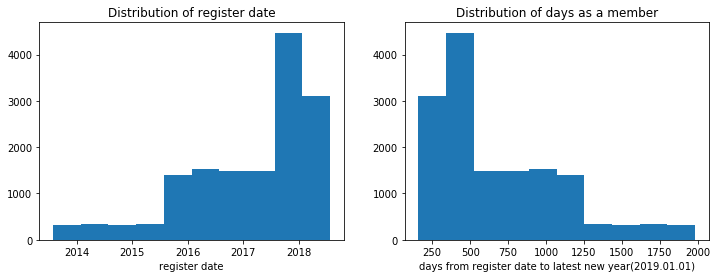

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(data=profile, x='register_date')
plt.title('Distribution of register date')
plt.xlabel('register date')

plt.subplot(1,2,2)
plt.hist(data=profile, x='member_days')
plt.title('Distribution of days as a member')
plt.xlabel('days from register date to latest new year(2019.01.01)')

plt.show()

# after visualization delete useless columns
profile.drop(columns=['became_member_on', 'register_date'], inplace=True )

### 2. Merge the dataset to combine all the potential features 

In [7]:
target_dataset = target_dataset.merge(portfolio, how='left', on='offer_id').merge(profile, how='left', on='person')

In [8]:
target_dataset

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,income,member_days
0,3,3,0.0,0.25,",5.5",5.50,19.89,1,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75,100000.0,602
1,3,7,7.0,9.00,9.25,9.25,19.67,1,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,F,75,100000.0,602
2,3,0,17.0,17.00,",21.25",21.25,21.72,1,10.0,10.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75,100000.0,602
3,3,8,21.0,24.25,",21.25",21.25,21.72,1,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,F,75,100000.0,602
4,5,9,0.0,0.75,NaN,NaN,0.00,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,M,68,70000.0,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66501,5639,-1,NaN,NaN,-1,NaN,0.00,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,66,34000.0,459
66502,15391,-1,NaN,NaN,-1,NaN,0.00,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,91,70000.0,1184
66503,872,-1,NaN,NaN,-1,NaN,0.00,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,72,35000.0,444
66504,14763,-1,NaN,NaN,-1,NaN,0.00,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,54,72000.0,725


## <a class="anchor" id="2">[II. Segement of the Person](#Start)</a>
Since there are too many individuals, it's better to set some customer groups to excavate more common pattern in each group.<br>
According to [References[1]](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb) and [References[3]](https://www.pewresearch.org/topics/generations-and-age/), there is a definition of generations based on age in 2019.
<img src="./images/generations_age.png"/>

### 1. Segment of target_dataset based on 'age' and 'income' 

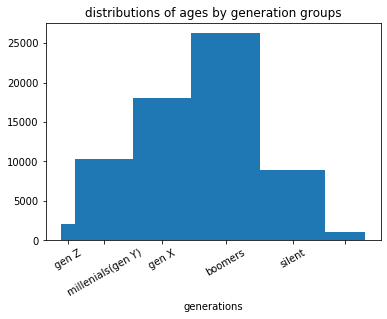

In [9]:
# distribution of age according to the definition of generations
# Based on the year 2018: the age edge as bins
age_min=target_dataset.age.min()  # 18 years old
age_max=target_dataset.age.max() # 101 years old
# cut the edge of generations
bins = [age_min, 22, 38, 54, 73, 91, age_max+1]
plt.hist(data=target_dataset, x='age' ,bins=bins);

plt.title('distributions of ages by generation groups')
plt.xlabel('generations')

ticks_loc = [20, 30, 46, 63.5, 82, 96.5]
ticks_label = ['gen Z', 'millenials(gen Y)', 'gen X', 'boomers', 'silent']
plt.xticks(ticks_loc, ticks_label, rotation=30) 

plt.show()

Besides, we can use also other informations(gender, income, member_days etc.) together to divide customer groups.<br>
Since the groups of `gen Z`(18-21) and the elder than `silent` are small, and the age is closed to the generation group nearby, so we finally make the segement as follows:
- age
- income

P.S.
I've tried according to 'age' & 'gender', but there is an value 'O' in gender, and makes the dataset unbalanced, so I decide to choose another method to segment the person.

According to [References[4]](https://en.wikipedia.org/wiki/Income_tax_in_the_United_States#Marginal_tax_rates_for_2019), we get the `single taxable income` of Americans in 2018.
<img src='./images/tax.png'>

Choose the segment method as follow:  

|Segment #| Age Group (edge included)<br> (Experiment in 2018) | Income | 
|---| --- | --- | 
|1| Millenials(-21 & 22-37) | low  | 
|2| Millenials(-21 & 22-37) | medium  | 
|3| Millenials(-21 & 22-37) | high  | 
|4| Gen X(38-53) | low  |
|5| Gen X(38-53) | medium |
|6| Gen X(38-53) | high |
|7| Baby Boomer(54-72) | low  |
|8| Baby Boomer(54-72) | medium |
|9| Baby Boomer(54-72) | high |
|10| Silent(73-90 & 91+) |low |
|11| Silent(73-90 & 91+) | medium |
|12| Silent(73-90 & 91+) | high |

**Notice:**  
- low: 30,000-50,000
- medium: 50,001-82,500
- high: 82,501-120,000

In [10]:
def segment_age_income(target_dataset):
    '''Make a segment to target_dataset.

    INPUT:
        - target_dataset(DataFrame)
    OUTPUT:
        - segment_dfs(list of 12 DataFrames): segment the target_dataset into 12 segments(DataFrames)
    '''
    segment_dfs=[]

    age_min=target_dataset.age.min()  #18
    age_max=target_dataset.age.max() #101
    age_begins = [age_min, 38, 54, 73]
    age_ends  = [38, 54, 73, age_max+1]


    income_min = target_dataset.income.min() #30,000
    income_max = target_dataset.income.max() #120,000
    income_begins = [income_min, 50000, 82500]
    income_ends = [50000, 82500, income_max+1]

    for age_seg_begin, age_seg_end in zip(age_begins, age_ends):
        is_age = (target_dataset.age >= age_seg_begin) & (target_dataset.age < age_seg_end)

        for income_seg_begin, income_seg_end in zip(income_begins, income_ends):
            is_income = (target_dataset.income >= income_seg_begin) & (target_dataset.income < income_seg_end)

            is_segment = (is_age & is_income)
            segment_dfs.append(target_dataset[is_segment])

    return segment_dfs

segment_dfs = segment_age_income(target_dataset)

In [11]:
# count each segment, in all 12 segments
segment_count_list = []
for idx in range(0, 12):
    segment_count_list.append(segment_dfs[idx].shape[0])

In [12]:
print("the number of all records in segments_dfs is {}" .format(sum(segment_count_list)))
print("the number of records in the original target_dataset is {}" .format(target_dataset.shape[0]))
segment_count_list

the number of all records in segments_dfs is 66506
the number of records in the original target_dataset is 66506


[5806, 6465, 118, 4404, 10017, 3573, 4990, 13295, 7962, 1769, 5018, 3089]

[Text(0, 0, 'Millenials'),
 Text(0, 0, 'Gen X'),
 Text(0, 0, 'Boomer'),
 Text(0, 0, 'Silent')]

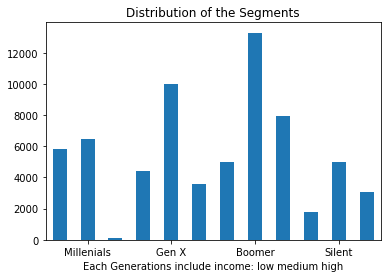

In [13]:
ax = (pd.Series(segment_count_list)).plot(kind="bar", rot=0);
xticks_loc = range(1, 11, 3)
xticks_label = ['Millenials', 'Gen X', 'Boomer', 'Silent']

ax.set_title('Distribution of the Segments')
ax.set_xlabel('Each Generations include income: low medium high')
ax.set_xticks(xticks_loc)
ax.set_xticklabels(xticks_label)

- Get the segments DataFrames `segment_dfs[0...11]`
- FOUND
    - the distribution of income is leike gauss-distribution. 
    - Only in Millenianls is unbalacend, for heuristic analyzation is not a big problem.

## <a class="anchor" id="3">[III. Classes of responsiveness to the offers](#Start)</a>
The all possible responsiveness defined as follows:<br>

|Group| received | viewed |valid completed | transaction amount |Scenario |
| :-| :-: | :-:| :-: | :-: | :- |
|1.none_offer| 0 | 0 | 0 | |haven't received the offer |
|2.no_care | 1 | 0 | - | |received but not viewed.<br> regarded as no_care|
|| 1 | 1 | 0 | =0.0 | received, viewed but no transaction |
|| 1 | 1 | 1<br>viewed after completed |  | received, but completed unintentionally |
|3.tried| 1 | 1 | 0 | >0.0|received, viewed, have transaction, but not fulfill the 'difficulty' |
|4.effctive_offer | 1 | 1 | 1<br>viewed before completed | | viewed before completed,  effctive offer|

**NOTE：**
1. **'valid completed'**, means complete within the duration of the offer<br>
2. States like 0,0,1 or 0,1,0 or 0,1,1 are impossible in reality.
3. `label_effective_offer == '1'` means received and is a valid completed<br>

**Response GROUPs:**
1. `none_offer`(passive)<br>
    - I. not received, not viewed
        - `label_effective_offer`.isin([-1, -2]) & `time_viewed` == NaN 
2. `no_care`(active)<br>
    - I. received, but not viewed
        - `label_effective_offer`.isin([0, 1]) & `time_viewed` == NaN
    - II. received, viewed, but no transaction
        - `label_effective_offer` == 0 & `amount` == 0.0 & `time_viewed`.notnull() 
    - or III. received, viewed, completed but viewed time after completed time
        - `label_effective_offer` == 1 & `time_viewed` > `time_completed` #when time_viewed is NaN, always False
3. `tried`<br>
    - I. received, viewed, have transaction but not valid completed
        - `label_effective_offer` == 0 & `amount` > 0.0  & `time_viewed`.notnull() 
4. `effctive_offer`<br>
    - I. received, viewed, and completed, besides viewed time before completed time
        - `label_effective_offer` == 1 & `time_viewed` < `time_completed` #when time_viewed is NaN, always False

### <a class="anchor" id="3.1">[1. Divide the response into 4 groups](#Start)</a>

The dataset structure:
<img src='./images/segment_group.png'>
1. Divide into 4 groups
2. Combine groups as different cases/situations according to the question

In [14]:
def group_none_offer(segment_dfs):
    '''Group 1. person haven't received any offer.'''
    segment_grouped = []
    for segment_df in segment_dfs:
        is_group = (segment_df.label_effective_offer.isin([-1, -2])) & (segment_df.time_viewed.isna())     #.isnull() .isna(); np.nan()
        segment_grouped.append(segment_df[is_group])
    
    return segment_grouped

In [15]:
def group_no_care(segment_dfs):
    '''Group 2. person don't care about the offer.'''
    segment_grouped = []
    for segment_df in segment_dfs:
        is_group_no_view = (segment_df.label_effective_offer.isin([0, 1])) & (segment_df.time_viewed.isna())
        is_group_no_trans = (segment_df.label_effective_offer == 0) & (segment_df.amount_with_offer == 0)  & (segment_df.time_viewed.notnull())#0和0.0没有区别
        is_group_later_view = (segment_df.label_effective_offer == 1) & (segment_df.time_viewed > segment_df.time_completed) 
        
        is_group = is_group_no_view | is_group_no_trans | is_group_later_view 
        segment_grouped.append(segment_df[is_group])
    
    return segment_grouped

In [16]:
def group_tried(segment_dfs):
    '''Group 3. person tried.'''
    segment_grouped = []
    for segment_df in segment_dfs:
        is_group = (segment_df.label_effective_offer == 0) & (segment_df.amount_with_offer > 0) & (segment_df.time_viewed.notnull())
        segment_grouped.append(segment_df[is_group])
    
    return segment_grouped

In [17]:
def group_effctive_offer(segment_dfs):
    '''Group 4. effctive_offer.
    '''
    segment_grouped = []
    for segment_df in segment_dfs:
        is_group = (segment_df.label_effective_offer == 1) & (segment_df.time_viewed <= segment_df.time_completed) 
        segment_grouped.append(segment_df[is_group])
    
    return segment_grouped

In [18]:
# none_offer group in segment DataFrame formed a list with 12 segments
# you can check:all time_viewed are NaNs
none_offer_segment_list = group_none_offer(segment_dfs)

# no_care group in segment DataFrame formed a list with 12 segments
# you can check: some time_viewed is after time_completed
no_care_segment_list = group_no_care(segment_dfs)

# tried group in segment DataFrame formed a list with 12 segments
tried_segment_list = group_tried(segment_dfs)

# effctive_offer group in segment DataFrame formed a list with 12 segments
effctive_offer_segment_list = group_effctive_offer(segment_dfs)

### <a class="anchor" id="3.2">[2. CHECK the dividing method for the 4 groups of response to offer](#Start)</a>

In [19]:
# CHECK the 12 segments: the number of records are same XXXX
segment_records =[]
for segment_df in segment_dfs:
    segment_records.append(segment_df.shape[0])

print(sum(segment_records))
segment_records  #segments data

66506


[5806, 6465, 118, 4404, 10017, 3573, 4990, 13295, 7962, 1769, 5018, 3089]

In [20]:
# CHECK the method of dividing the 4 groups of response:
# each segment(DataFrame) should have the same number of records
group_records = []
for idx in range(0,12):
    segment_size = none_offer_segment_list[idx].shape[0] + no_care_segment_list[idx].shape[0]+tried_segment_list[idx].shape[0]+effctive_offer_segment_list[idx].shape[0]
    group_records.append(segment_size)

print(sum(group_records))
group_records

66506


[5806, 6465, 118, 4404, 10017, 3573, 4990, 13295, 7962, 1769, 5018, 3089]

- Conclusion from the result: <br>
the dividing method of response to offer groups is correct.

### <a class="anchor" id="3.3">[3. Heuristic exploration in 4 aspects](#Start)</a>

In [21]:
# 1.divided to 4 response gourps
# 2.lebel for segment and group
def reconstruct_target_group(case_one_list, case_two_list, name_situation, name_case_one='case_one', name_case_two='case_two'):
    '''
    DESCRIPTION:
        reconstruct the target group based on the 4 groups of segments: none_offer_segment_list, no_care_segment_list, tried_segment_list and effctive_offer_segment_list

    INPUT:
        - case_one_list: list of grouped segments(DataFrames list), eg. [no_care_segment_list]
        - case_two_list: to be compared with case_one, eg. [tried_segment_list, effctive_offer_segment_list]
        - name_situation(str): new column name to describe the concerned situation
        - name_case_one(str): name of the first case of concerned situation
        - name_case_two(str): name of the second case of concerned situation
    
    OUTPUT:
        - combined_case(12 DataFrames): each DataFrame is correspond to the situation with labels
    '''
    case_one = [None] * 12
    case_two = [None] * 12
    combined_case = [None] * 12

    # deal with 12 segments one by once
    for idx in range(0, 12):
        # each loop for one segment for case one
        case_one_segment = [group_segment[idx] for group_segment in case_one_list]
        case_one[idx] = pd.concat(case_one_segment, axis=0)
        case_one[idx][name_situation]= name_case_one

        # each loop for one segment for case two
        case_two_segment = [group_segment[idx] for group_segment in case_two_list]
        case_two[idx] = pd.concat(case_two_segment, axis=0)
        case_two[idx][name_situation]= name_case_two

        combined_case[idx] = pd.concat([case_one[idx], case_two[idx]], axis=0)
        combined_case[idx]['label_seg'] = idx + 1  #segment #1-#12

    return combined_case

### <a class="anchor" id="3.3.1">[`3.1` Offer Distributions: none_offer VS. others](#Start)</a>
1. Case one with:
    - none_offer_segment_list
2. Case two with:
    - no_care_segment_list
    - tried_segment_list
    - effctive_offer_segment_list

In [22]:
case_one_list = [none_offer_segment_list]
case_two_list = [no_care_segment_list, tried_segment_list, effctive_offer_segment_list]
name_situation = 'Offer_Distributions'
name_case_one='none_offer'
name_case_two='with_offer'

combined_segment_with_label = reconstruct_target_group(case_one_list, case_two_list, name_situation, name_case_one, name_case_two)

# !!!CHECK
len_lst = []
# 12 segments
for idx in range(0, 12):
    len_lst.append(combined_segment_with_label[idx].shape[0])
print(sum(len_lst))
len_lst

66506


[5806, 6465, 118, 4404, 10017, 3573, 4990, 13295, 7962, 1769, 5018, 3089]

In [23]:
# combine all segments to one DataFrame
# 12 segments

# initial with the 1st segment
summary_dataset = combined_segment_with_label[0]
# append another 11 segments
for idx in range(1, 12):
    summary_dataset = summary_dataset.append(combined_segment_with_label[idx])

summary_dataset

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,Offer_Distributions,label_seg
90,41,4,17.0,NaN,",17.5",NaN,3.18,0,5.0,20.0,...,1.0,0.0,0.0,1.0,F,20,30000.0,904,with_offer,1
144,9885,4,7.0,NaN,",7.75,8.0,8.75,12.5,16.25",NaN,9.67,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,27,44000.0,432,with_offer,1
145,9885,3,14.0,NaN,",16.25,19.5,20.5",NaN,7.87,0,5.0,5.0,...,1.0,1.0,0.0,1.0,M,27,44000.0,432,with_offer,1
147,9885,6,24.0,25.25,",24.5,24.75",24.75,1.84,1,2.0,10.0,...,1.0,1.0,1.0,1.0,M,27,44000.0,432,with_offer,1
196,82,4,21.0,NaN,",22.5,25.0,26.5,27.75,28.0,29.0",NaN,15.40,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,27,35000.0,356,with_offer,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66378,10275,9,17.0,19.75,",21.0",21.00,23.13,1,2.0,10.0,...,1.0,1.0,0.0,1.0,F,76,115000.0,1123,with_offer,12
66462,12602,4,17.0,17.50,",18.25",18.25,22.08,1,5.0,20.0,...,1.0,0.0,0.0,1.0,M,77,96000.0,353,with_offer,12
66468,14435,6,17.0,17.00,",21.5",21.50,25.35,1,2.0,10.0,...,1.0,1.0,1.0,1.0,F,87,95000.0,1050,with_offer,12
66469,14435,6,24.0,24.00,",24.5",24.50,36.30,1,2.0,10.0,...,1.0,1.0,1.0,1.0,F,87,95000.0,1050,with_offer,12


**Notice:**  
The last two column `Offer_Distributions`, `label_seg`

### Visualization

In [24]:
# Encode dict for segments
seg_encode = {1: 'Millenials(-21&22-37) low',
              2: 'Millenials(-21&22-37) medium',
              3: 'Millenials(-21&22-37) high',
              4: 'Gen X(38-53) low',
              5: 'Gen X(38-53) medium',
              6: 'Gen X(38-53) high',
              7: 'Baby Boomer(54-72) low',
              8: 'Baby Boomer(54-72) medium',
              9: 'Baby Boomer(54-72) high',
              10: 'Silent(73-90 & 91+) low',
              11: 'Silent(73-90 & 91+) medium',
              12: 'Silent(73-90 & 91+) high'}

In [25]:
def visualize_countplot(name_situation, name_case_one, name_case_two, data, seg_encode, count_dataset):

    color_cold = sb.color_palette("RdBu", n_colors=7)[4]
    color_warm = sb.color_palette()[1]
    color_hline = sb.color_palette()[0]

    # a group of countplots: 12 segments(each segment is a countplot)
    g = sb.catplot(x="offer_id", hue=name_situation, col="label_seg", col_wrap=3, 
                   hue_order=[name_case_one, name_case_two],
                   data=data, kind="count",height=4, aspect=1, 
                   palette=[color_cold, color_warm], legend=True);

    # set a title 
    plt.subplots_adjust(top=0.92, hspace=0.4);
    g.fig.suptitle('The {} for different Offers: {} or {}'.format(name_situation, name_case_one, name_case_two))


    # horizontal lines for mean values for two group
    # 1st case
    is_case_one = (summary_dataset[name_situation] == name_case_one) #
    dataset_case_one = summary_dataset[is_case_one]


    # 2nd case 
    is_case_two = (summary_dataset[name_situation] == name_case_two) #
    dataset_case_two = summary_dataset[is_case_two]


    # calculate mean values
    case_one_means = [None]*12
    case_two_means = [None]*12

    for idx in range(0,12):
        # calculate the means of two cases in 12 segments
        
        is_segment_one = (dataset_case_one.label_seg == idx+1)
        dataset_case_one_seg = dataset_case_one[is_segment_one]
        # 10 offers
        case_one_mean = dataset_case_one_seg.offer_id.count() / 10
        case_one_means[idx] = case_one_mean

        is_segment_two = (dataset_case_two.label_seg == idx+1)
        dataset_case_two_seg = dataset_case_two[is_segment_two]
        case_two_mean = dataset_case_two_seg.offer_id.count() / 10
        case_two_means[idx] = case_two_mean



    for idx, ax in enumerate(g.axes.flatten()):
        # give each subplot a xlabel
        ax.tick_params(labelbottom=True)
        # give each subplot a title
        ax.set_title('Segment #{}: {}\n The total number is {}' .format(idx+1, seg_encode[idx+1], count_dataset[idx].shape[0]))
        # horizontal line to describe mean of case one
        ax.hlines(case_one_means[idx], -0.5, 11, color=color_cold, linewidth=1)
        # horizontal line to describe mean of case two
        ax.hlines(case_two_means[idx], -0.5, 11, color=color_warm, linewidth=1)

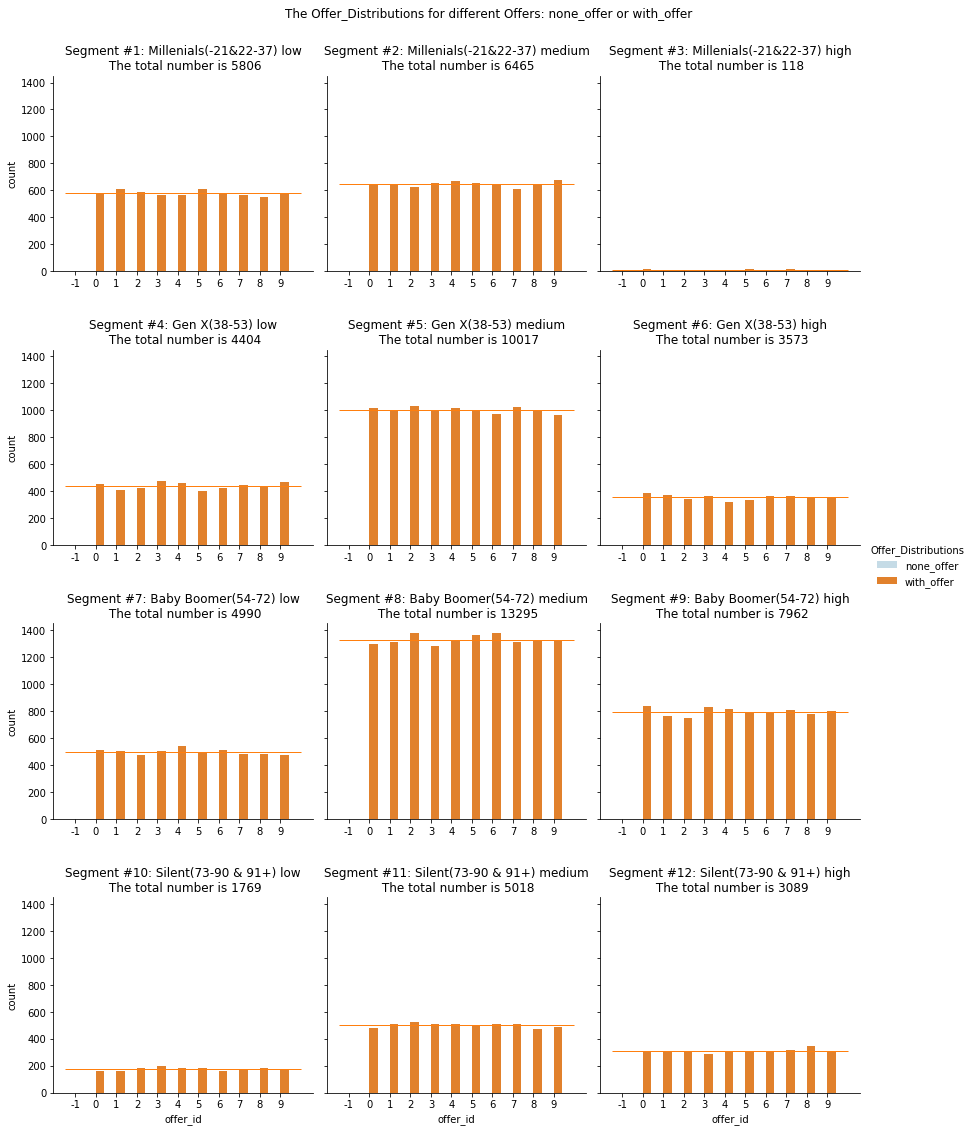

In [26]:
visualize_countplot(name_situation, name_case_one, name_case_two, summary_dataset, seg_encode, combined_segment_with_label)

**FOUND:**
- The number of 'none_offer' is very small

In [27]:
# the whole group of offer not received
is_none_offer = (summary_dataset.offer_id == '-1')
summary_dataset[is_none_offer]

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,Offer_Distributions,label_seg
66501,5639,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,F,66,34000.0,459,none_offer,7
66503,872,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,F,72,35000.0,444,none_offer,7
66504,14763,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,F,54,72000.0,725,none_offer,8
66505,6789,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,F,55,88000.0,868,none_offer,9
66502,15391,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,M,91,70000.0,1184,none_offer,11


### [3.1 Conclusion](#Start)
**Notice:**
1. `offer_id == -1` means person haven't received any offer

2. These 5 person(`offer_id=='-1'`) are the whole `label_effective_offer == -2` group

### 3.1.i. In general: offer distribution
1. There are just 5 person, who never received the offer  
    - 2 in `segment \#7`
    - 1 in `segment \#8 \#9 \#11`
  
2. The offer distributions under income: See `segment \#3` VS. `segment \#12`  
    - Young people have not so much money. 
    - Elder people tend to have more savings.

3. The offer distributions under age: See `segment \#1` VS. `segment \#10`
    - In the low income group, compared with young person, the elder person seems to receive less offers

### 3.1.ii. In segments(subplots)
1. In each segment, person reveive almost the same quantity of offers 
2. In `Segment \#3`
    - Young person tends to lack of a big savings.

### <a class="anchor" id="3.3.2">[`3.2` Interest Distributions: no_care VS. care (tried & effective_offer)](#Start)</a>
1. Case one with:
    - no_care_segment_list
2. Case two with:
    - tried_segment_list
    - effctive_offer_segment_list

In [28]:
case_one_list = [no_care_segment_list]
case_two_list = [tried_segment_list, effctive_offer_segment_list]
name_situation = 'Interest_Distributions'
name_case_one='no_care'
name_case_two='tried or effctive'

combined_segment_with_label = reconstruct_target_group(case_one_list, case_two_list, name_situation, name_case_one, name_case_two)

# combine all segments to one DataFrame
# 12 segments
# initial with the 1st segment
summary_dataset = combined_segment_with_label[0]
# append another 11 segments
for idx in range(1, 12):
    summary_dataset = summary_dataset.append(combined_segment_with_label[idx])

summary_dataset

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,Interest_Distributions,label_seg
90,41,4,17.0,NaN,",17.5",NaN,3.18,0,5.0,20.0,...,1.0,0.0,0.0,1.0,F,20,30000.0,904,no_care,1
144,9885,4,7.0,NaN,",7.75,8.0,8.75,12.5,16.25",NaN,9.67,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,27,44000.0,432,no_care,1
145,9885,3,14.0,NaN,",16.25,19.5,20.5",NaN,7.87,0,5.0,5.0,...,1.0,1.0,0.0,1.0,M,27,44000.0,432,no_care,1
147,9885,6,24.0,25.25,",24.5,24.75",24.75,1.84,1,2.0,10.0,...,1.0,1.0,1.0,1.0,M,27,44000.0,432,no_care,1
196,82,4,21.0,NaN,",22.5,25.0,26.5,27.75,28.0,29.0",NaN,15.40,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,27,35000.0,356,no_care,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66378,10275,9,17.0,19.75,",21.0",21.00,23.13,1,2.0,10.0,...,1.0,1.0,0.0,1.0,F,76,115000.0,1123,tried or effctive,12
66462,12602,4,17.0,17.50,",18.25",18.25,22.08,1,5.0,20.0,...,1.0,0.0,0.0,1.0,M,77,96000.0,353,tried or effctive,12
66468,14435,6,17.0,17.00,",21.5",21.50,25.35,1,2.0,10.0,...,1.0,1.0,1.0,1.0,F,87,95000.0,1050,tried or effctive,12
66469,14435,6,24.0,24.00,",24.5",24.50,36.30,1,2.0,10.0,...,1.0,1.0,1.0,1.0,F,87,95000.0,1050,tried or effctive,12


**Notice:**  
5 person with none_offer reduced 

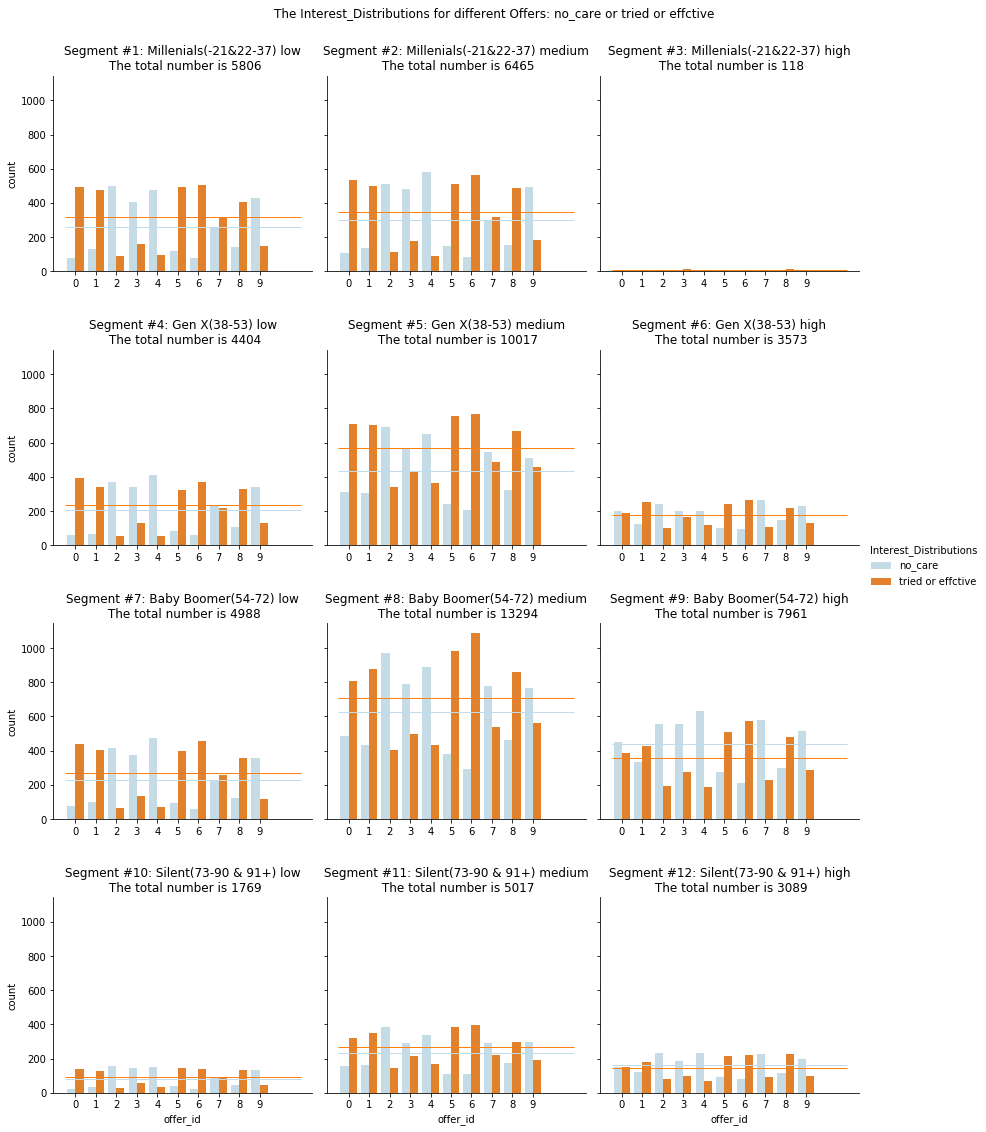

In [29]:
visualize_countplot(name_situation, name_case_one, name_case_two, summary_dataset, seg_encode, combined_segment_with_label)

### [3.2 Conclusion](#Start)

**Notice:** the details of offer_id(10 kinds)
<img src='./images/offer_info.png'>

In [30]:
# offer 0, 1, 5, 6, 8
portfolio_raw[portfolio_raw.offer_id.isin(['0','1','5','6','8'])]

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,0,1,1,1,0
1,10,10,5,bogo,1,1,1,1,1
5,3,7,7,discount,5,1,1,1,1
6,2,10,10,discount,6,1,1,1,1
8,5,5,5,bogo,8,1,1,1,1


In [31]:
# offer 2, 3, 4
portfolio_raw[portfolio_raw.offer_id.isin(['2','3','4'])]

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
2,0,0,4,informational,2,1,1,0,1
3,5,5,7,bogo,3,1,1,0,1
4,5,20,10,discount,4,1,0,0,1


In [32]:
# offer 7, 9
portfolio_raw[portfolio_raw.offer_id.isin(['7','9'])]

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
7,0,0,3,informational,7,1,1,1,0
9,2,10,7,discount,9,1,1,0,1


### 3.2.i. In general: Interst distribution under different offers
1. people care more about offer 0, 1, 5, 6, 8
2. offer 2, 3, 4 are not in interest
3. for offer 7, 9, some care, some don't care   
     
From the three tables above, we can conclude that:
- 'social' is an import factor to attract people to complete the offer
- 'bogo' with medium difficulty are more popular
- 'discount' with less difficulty are more popular  


### 3.2.ii. In segments(subplots)
1. offer 0, 1
    - the high income groups show less interst compared with other income group.(see `Segments \#3 \#6 \#9 \#12`)

2. offer 5, 6, 8
    - person shows great interst(in all Segments)

### <a class="anchor" id="3.3.3">[`3.3` Difficulty Distributions: tried VS. effective_offer](#Start)</a>
1. Case one
    - tried_segment_list
2. Case two
    - effctive_offer_segment_list 

In [33]:
case_one_list = [tried_segment_list]
case_two_list = [effctive_offer_segment_list]
name_situation = 'Difficulty_Distributions'
name_case_one='tried but failed'
name_case_two='effctive'

combined_segment_with_label = reconstruct_target_group(case_one_list, case_two_list, name_situation, name_case_one, name_case_two)

# combine all segments to one DataFrame
# 12 segments
# initial with the 1st segment
summary_dataset = combined_segment_with_label[0]
# append another 11 segments
for idx in range(1, 12):
    summary_dataset = summary_dataset.append(combined_segment_with_label[idx])
summary_dataset #(34888, 22)

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,Difficulty_Distributions,label_seg
89,41,0,0.0,0.00,",0.0,0.25,0.5,3.5,3.75,4.25,5.5,6.0",NaN,25.49,0,10.0,10.0,...,1.0,1.0,1.0,0.0,F,20,30000.0,904,tried but failed,1
143,9885,1,0.0,2.00,",2.0,3.25",NaN,4.28,0,10.0,10.0,...,1.0,1.0,1.0,1.0,M,27,44000.0,432,tried but failed,1
146,9885,6,21.0,22.00,",22.75,23.25,23.5,24.5,24.75,25.5,28.0,29.5",NaN,23.99,0,2.0,10.0,...,1.0,1.0,1.0,1.0,M,27,44000.0,432,tried but failed,1
197,82,8,24.0,24.25,",25.0,26.5,27.75,28.0,29.0",NaN,8.48,0,5.0,5.0,...,1.0,1.0,1.0,1.0,M,27,35000.0,356,tried but failed,1
442,156,3,0.0,1.00,",4.5,6.0",NaN,9.58,0,5.0,5.0,...,1.0,1.0,0.0,1.0,F,18,49000.0,587,tried but failed,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66378,10275,9,17.0,19.75,",21.0",21.00,23.13,1,2.0,10.0,...,1.0,1.0,0.0,1.0,F,76,115000.0,1123,effctive,12
66462,12602,4,17.0,17.50,",18.25",18.25,22.08,1,5.0,20.0,...,1.0,0.0,0.0,1.0,M,77,96000.0,353,effctive,12
66468,14435,6,17.0,17.00,",21.5",21.50,25.35,1,2.0,10.0,...,1.0,1.0,1.0,1.0,F,87,95000.0,1050,effctive,12
66469,14435,6,24.0,24.00,",24.5",24.50,36.30,1,2.0,10.0,...,1.0,1.0,1.0,1.0,F,87,95000.0,1050,effctive,12


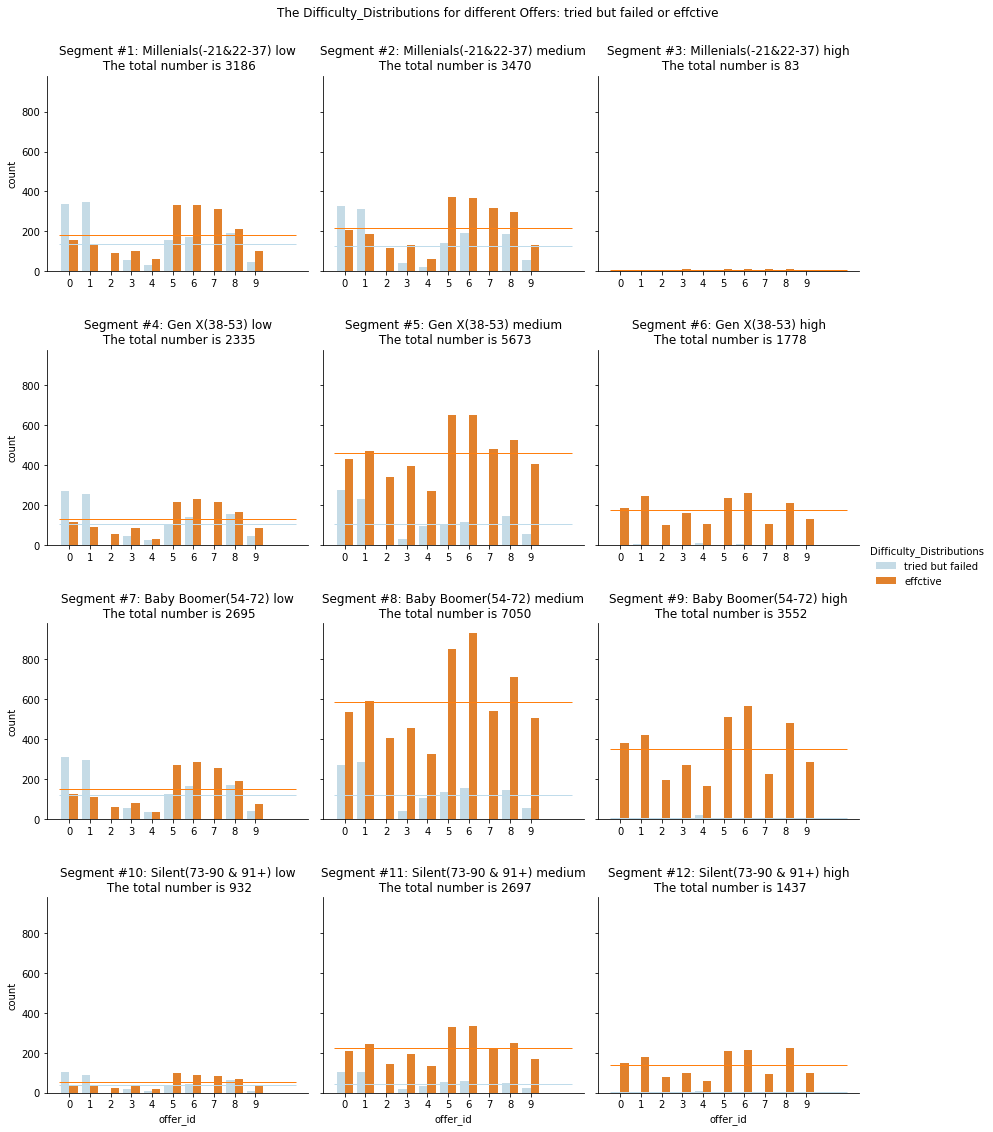

In [34]:
visualize_countplot(name_situation, name_case_one, name_case_two, summary_dataset, seg_encode, combined_segment_with_label)

### [3.3 Conclusion](#Start)

In [35]:
# offer 5, 6, 8
portfolio_raw[portfolio_raw.offer_id.isin(['5','6','8'])]

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
5,3,7,7,discount,5,1,1,1,1
6,2,10,10,discount,6,1,1,1,1
8,5,5,5,bogo,8,1,1,1,1


In [36]:
# offer 0,1
portfolio_raw[portfolio_raw.offer_id.isin(['0','1'])]

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,0,1,1,1,0
1,10,10,5,bogo,1,1,1,1,1


### 3.3.i. In general: Degree of completion
1. Offer 5, 6, 8 are better completed
    - there is 'social' factor
    - 'difficulty' is not so much
  <br>
2. Offer 0, 1 are harder to complete
    - compared with 'reward', the 'difficulty' is even more
    <br>
3. Offer 7: an informational offer
    - richer people don't care (see `Segment \#6 \#9 \12`)
    - more attracted to less rich people
    <br>
4. Offer 2, 3, 4 are more attracted in medium elder and rich people (see `Segment \#5 \#8`)
    <br>  
5. The person with high income tends to complete all offers (see `Segment \#6 \#9 \#12`)
    - even under the offer 0, 1

### <a class="anchor" id="3.3.4">[`3.4` Index IIR: Is the offer significant popular?](#Start)</a>
Definition of IIR: Incremental Response Rate
$$IIR= \frac{n_1}{sum_1}-\frac{n_0}{sum_0} $$ <br>

| Symbol | Meaning |
| :- | :- |
| $$n_1$$ | number of Purchasers in Treated Group |
| $$sum_1$$ | Total number of Purchasers in Treated Group |
| $$n_0$$ | number of Purchasers in Control Group |
| $$sum_0$$ | Total number of Purchasers in Control Group |

1. Total number in Control Group: 
    - i. not viewed, no matter received or not
        - `time_viewed == NaN` # the special 5 person with `label_effective_offer == -2`
    - ii. viewed after completed
        - `label_effective_offer == 1` & `time_viewed > time_completed`  
  
n0 is the subset: (`label_effective_offer == 1`) in control group

2. Total number in Treated Group:
    - i. viewed before completed, when there is 'completed'
        - `label_effective_offer == 1` & `time_viewed < time_completed` 
    - ii. viewed, when there is 'no completed'
        - `label_effective_offer == 0` & `time_viewed >= 0.0 ` 
        
n1 is the subset(`label_effective_offer == 1`) in control group

In [37]:
def group_control(segment_dfs):
    '''Get the ratio statistiks of control group.

    INPUT:
        - segment_dfs(list of 12 DataFrames): segment the target_dataset into 12 segments(DataFrames)
    OUTPUT:
        - stats_offers(list): n0/sum0 reference to IIR formula(12 segments * 10 offers)
    '''
    # 12 segments, each segment has 10 offer statistiks
    offer_ids = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
    stats_offers = [] #list size: 12*10
    # in each segment
    for idx, segment_df in enumerate(segment_dfs):  #12
        is_none_view = (segment_df.time_viewed.isnull())
        is_viewed_after = (segment_df.label_effective_offer == 1) & (segment_df.time_viewed >= segment_df.time_completed)

        is_control_group = is_none_view | is_viewed_after
        control_df = segment_df[is_control_group]


        stats_offer_seg = []
        # for each offer_id
        for offer_id in offer_ids:
            is_offer = (control_df.offer_id == offer_id)
            control_offer_df = control_df[is_offer]

            sum_control = control_offer_df.shape[0]

            is_offer_completed = (control_offer_df.label_effective_offer == 1)
            n_control = control_offer_df[is_offer_completed].shape[0]

            # Exception: ZeroDivisionError
            try:
                stats = (n_control / float(sum_control))
            except ZeroDivisionError:
                stats = 0.0

            stats_offer_seg.append(stats)  # size: 10
        stats_offers.append(stats_offer_seg) # size: 12*10
    
    return stats_offers

In [38]:
def group_treated(segment_dfs):
    '''Get the ratio statistiks of treated group.

    INPUT:
        - segment_dfs(list of 12 DataFrames): segment the target_dataset into 12 segments(DataFrames)
    OUTPUT:
        - stats_offers(list): n1/sum1 reference to IIR formula(12 segments * 10 offers)
    '''
    # 12 segments, each segment has 10 offer statistiks
    offer_ids = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
    stats_offers = [] #list size: 12*10
    # in each segment
    for idx, segment_df in enumerate(segment_dfs):  #12
        is_viewed_before = (segment_df.label_effective_offer == 1) & (segment_df.time_viewed < segment_df.time_completed)
        is_viewed_fail = (segment_df.label_effective_offer == 0) & (segment_df.time_viewed >= 0.0)

        is_treated_group = is_viewed_before | is_viewed_fail
        treated_df = segment_df[is_treated_group]


        stats_offer_seg = []
        # for each offer_id
        for offer_id in offer_ids:
            is_offer = (treated_df.offer_id == offer_id)
            treated_offer_df = treated_df[is_offer]

            sum_treated = treated_offer_df.shape[0]

            is_offer_completed = (treated_offer_df.label_effective_offer == 1)
            n_treated = treated_offer_df[is_offer_completed].shape[0]

            # Exception: ZeroDivisionError
            try:
                stats = (n_treated / float(sum_treated))
            except ZeroDivisionError:
                stats = 0.0

            stats_offer_seg.append(stats)  # size: 10
        stats_offers.append(stats_offer_seg) # size: 12*10

    return stats_offers

In [39]:
stats_offers_control = group_control(segment_dfs) #(12, 10)
stats_offers_treated = group_treated(segment_dfs) #(12, 10)

In [40]:
print(np.array(stats_offers_control).shape)
print(np.array(stats_offers_treated).shape)

(12, 10)
(12, 10)


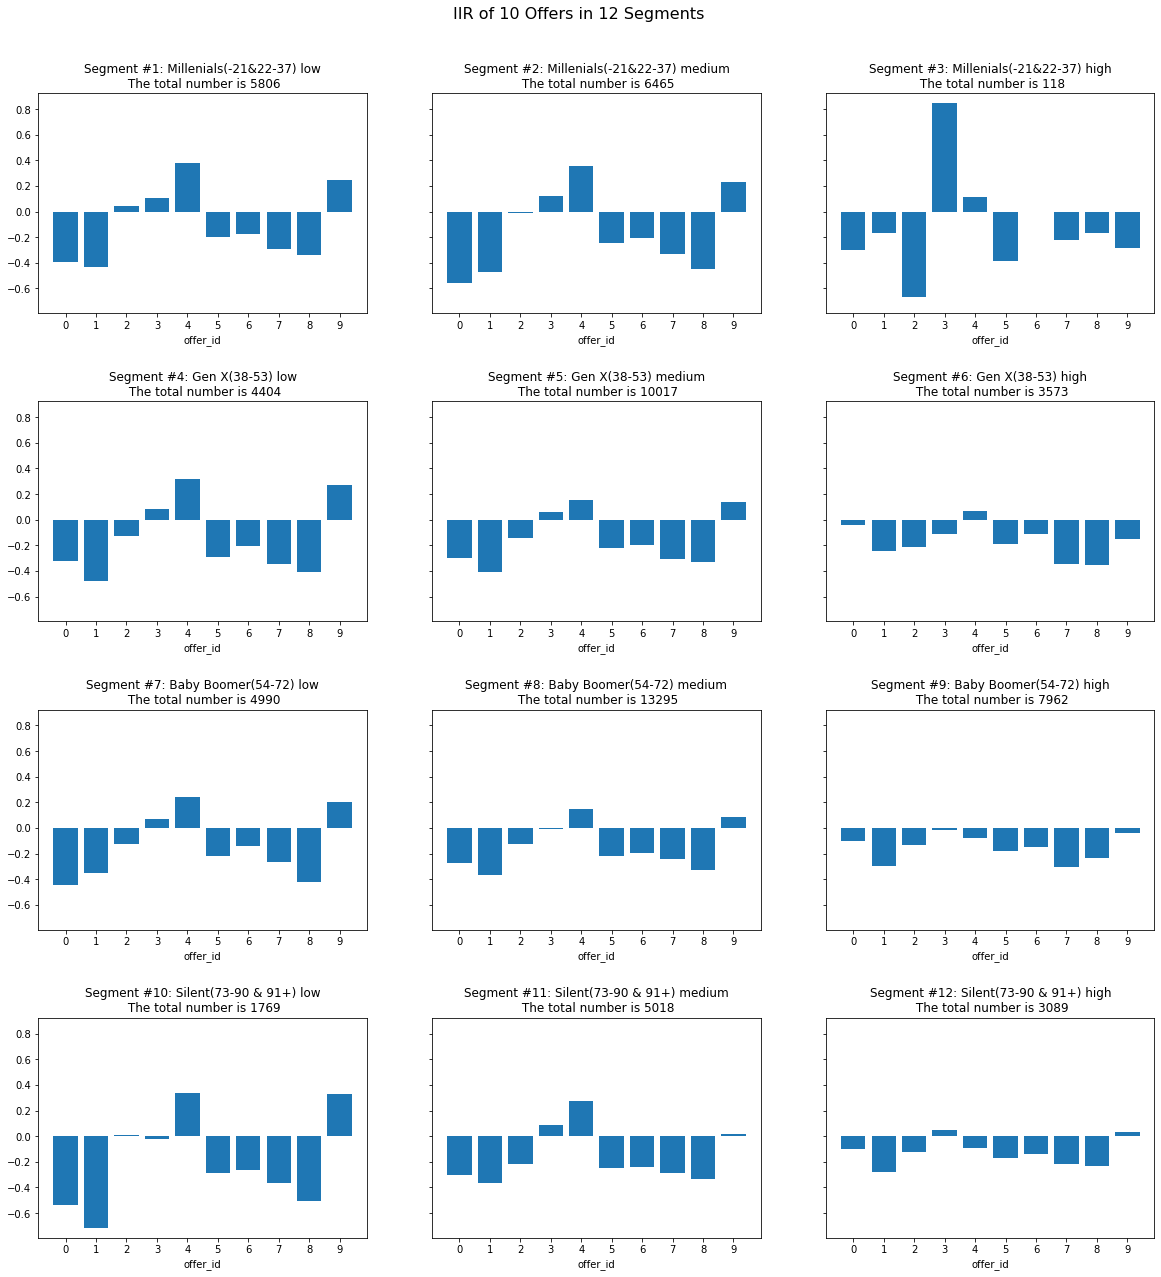

In [41]:
# visulization 12 segments(4 rows, 3 cols)
fig, axes = plt.subplots(figsize=(20, 20), nrows=4, ncols=3, sharex=True, sharey=True)  ## fig.add_axes(sharex=True, sharey=True)
plt.subplots_adjust(top=0.92, hspace=0.4);

fig.suptitle('IIR of 10 Offers in 12 Segments', fontsize=16)
axes = axes.flatten()

x = range(0, 10) 
y = np.array(stats_offers_treated) - np.array(stats_offers_control)  #(12,10)

# 12 segments
for seg_idx in range(0, 12):
    # for each segment plot a bar
    ax = axes[seg_idx]
    ax.bar(x, y[seg_idx])
    
    ax.set_title('Index: IIR')
    ax.set_xlabel('offer_id')
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.tick_params(labelbottom=True)
    ax.set_title('Segment #{}: {}\n The total number is {}' .format(seg_idx+1, seg_encode[seg_idx+1], segment_dfs[seg_idx].shape[0]))

**FOUND:**


### [3.4 Conclusion](#Start)

In [42]:
# offer 0,1,2,3,4
portfolio_raw[portfolio_raw.offer_id.isin(['0','1','2','3','4'])]

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,0,1,1,1,0
1,10,10,5,bogo,1,1,1,1,1
2,0,0,4,informational,2,1,1,0,1
3,5,5,7,bogo,3,1,1,0,1
4,5,20,10,discount,4,1,0,0,1


### 3.4.i. In general: which offer seems popular?
1. Offer 2, 3, 4 have positive IIR
    - for offer 4, the difficulty is 20, maybe few people want to complete it, so it shows high IIR
    - for offer 3, difficulty is not big, but reward is ok, so it's popular
<br>
2. Offer 0,1 have a huge negtive IIR
    - specially for the low income person(see `Segments \#1 \#4 \#7 \#10`)

### 3.4.ii. In segments(subplots)
1. The rich people seem not so excited about offer received(see `Segments \#6 \#9 \#12`)
    - Maybe they are too rich to be encouraged from the reward of offer

### <a class="anchor" id="3.4">[4. Summary](#Start)</a>

1. The way to send an offer
    - Through 'social' is a better way.
<br>
2. The type of offer
    - People like 'discount', because the reward is real money compared to 'bogo'(get another same thing) and 'informational'(just information)
<br>
3. The content of offer
    - If the difficulty is too much, e.g. 20, people have less desire to complete the offer
    - 5-10 maybe a good range of difficulty
<br>
4. for all offers considering of Interest(care) and Difficulty(degree of completion)
    - Offer 5, 6, 8 are more attracted and more easy to complete: could be sent to all people
    - Offer 0, 1 are hard to complete, but for high income people is not a problem
    - Offer 2, 3, 4 are more attracted to the medium elder, income people(`Segment \#5 \#8`)
    - Offer 7 for less income people(maybe the information is attracted by them)

## <a class="anchor" id="4">[IV. Save the dataset for ML modeling](#Start)</a>
1. 12 Segments, each is divided to 4 groups 
    - `none_offer_segment_list = group_none_offer(segment_dfs)`  

    - `no_care_segment_list = group_no_care(segment_dfs)`  

    - `tried_segment_list = group_tried(segment_dfs)`  

    - `effctive_offer_segment_list = group_effctive_offer(segment_dfs)`  

2. Combine the data together with 2 labels:
    - label of segment: `label_seg`
    - label of group: `label_group`

In [50]:
# 2 new columns for labeling
name_group = 'label_group'
name_seg = 'label_seg'


model_dataset_raw = pd.DataFrame()
# label_seg from 1 to 12 segment
for seg_idx in range(0, 12):
    # label for group
    none_offer_segment_list[seg_idx][name_group] = 'none_offer'  # there is empty DataFrame, can't use .loc[:, name_group]='none_offer'
    no_care_segment_list[seg_idx][name_group] = 'no_care'
    tried_segment_list[seg_idx][name_group] = 'tried'
    effctive_offer_segment_list[seg_idx][name_group] = 'effctive_offer'

    # label for segment
    none_offer_segment_list[seg_idx][name_seg] = seg_idx + 1
    no_care_segment_list[seg_idx][name_seg] = seg_idx + 1
    tried_segment_list[seg_idx][name_seg] = seg_idx + 1
    effctive_offer_segment_list[seg_idx][name_seg] = seg_idx + 1
    
    concat_df = pd.concat([none_offer_segment_list[seg_idx], no_care_segment_list[seg_idx], tried_segment_list[seg_idx], effctive_offer_segment_list[seg_idx]], axis=0)
    model_dataset_raw = model_dataset_raw.append(concat_df)

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [51]:
model_dataset_raw.sort_values('person', ascending=True, inplace=True)
model_dataset_raw

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,label_group,label_seg
53365,1,2,21.0,NaN,22.0,22.00,23.22,1,0.0,0.0,...,1.0,1.0,0.0,1.0,F,55,112000.0,535,no_care,9
53364,1,3,17.0,NaN,",22.0",22.00,23.22,1,5.0,5.0,...,1.0,1.0,0.0,1.0,F,55,112000.0,535,no_care,9
0,3,3,0.0,0.25,",5.5",5.50,19.89,1,5.0,5.0,...,1.0,1.0,0.0,1.0,F,75,100000.0,602,effctive_offer,12
1,3,7,7.0,9.00,9.25,9.25,19.67,1,0.0,0.0,...,1.0,1.0,1.0,0.0,F,75,100000.0,602,effctive_offer,12
2,3,0,17.0,17.00,",21.25",21.25,21.72,1,10.0,10.0,...,1.0,1.0,1.0,0.0,F,75,100000.0,602,effctive_offer,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54065,16998,3,17.0,21.50,",17.25",17.25,11.03,1,5.0,5.0,...,1.0,1.0,0.0,1.0,F,83,50000.0,1030,no_care,11
52227,16999,2,24.0,NaN,-1,NaN,0.00,0,0.0,0.0,...,1.0,1.0,0.0,1.0,F,62,82000.0,528,no_care,8
52228,16999,8,17.0,22.75,",20.0",20.00,30.57,1,5.0,5.0,...,1.0,1.0,1.0,1.0,F,62,82000.0,528,no_care,8
52225,16999,5,0.0,0.25,",2.25",2.25,21.55,1,3.0,7.0,...,1.0,1.0,1.0,1.0,F,62,82000.0,528,effctive_offer,8


**Notice** The last two columns:
- label_group
- label_seg

In [52]:
model_dataset_raw.label_group.unique()

array(['no_care', 'effctive_offer', 'tried', 'none_offer'], dtype=object)

In [53]:
model_dataset_raw.label_seg.unique()

array([ 9, 12,  8,  1,  5,  7, 11,  2,  4, 10,  6,  3], dtype=int64)

### Save the dataset
```python
model_raw_dataset.to_csv('./data_generated/model_raw_dataset.csv', index=False)
```

## <a class="anchor" id="References">[References](#Start)</a>
[[1]Starbucks Capstone Challenge: Using Starbucks app user data to predict effective offers](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)<br>
[[2]Starbucks Promotion Optimization](https://towardsdatascience.com/starbucks-promotion-optimization-ca56e29fb584)<br>
[[3]generations-and-age](https://www.pewresearch.org/topics/generations-and-age/)<br>
[[4]single taxable income](https://en.wikipedia.org/wiki/Income_tax_in_the_United_States#Marginal_tax_rates_for_2019)

## Tips(For myself)
0. 数据更新
    - 更新informational offer的time_complete: 也就是time_transaction

1. 逻辑判断
    - Series.isin(['2','7'])
    - Series == 1
element-wise: & | 

2. DataFrame 赋值
    - .loc[row_indexer,col_indexer] = value
    ```python
    target_dataset.loc[is_change_time_complete, 'time_completed'] 
        = target_dataset[is_change_time_complete]['time_transaction'].apply(lambda x: float(x))
    ```

3. 含nan的判断都是Fasle
    - 1.3>=np.nan
    - 1.3<=np.nan
    - np.nan<=1.3
    - np.nan==np.nan

### 可视化
1. FacetGrid没有考虑整体情况  
有的子图单个分类数据为0, 导致预设定的legend等标注的并非指定对象  
    - 选择catplot配合countplot

2. 添加legend
    ```python
g.add_legend(legend_data= {'none offer': g._legend_data['group one'], 'with offer': g._legend_data['group two']})  #delete original dict values
handles = g._legend_data.values()
plt.legend(handles, labels=[name_group_one, name_group_two], loc=2)  #指针对最后一个图
    ```

3. FacetGrid子图的title
    ```python
    g.set_titles("Segment #{col_name}")  #{col_var} is label_seg
    ```